# Exploratory Data Analysis: YouTube trending statistics

Contents:

1.  A summary of the notebook 'YouTube Trending Videos Analysis'. You guys will certaily know everything which I have written about this notebook already, and by the sound of it you have went into more depth than this notebook. This Kaggle kernel covers the basic properties of the US dataset, I did a little bit of work checking the properties of the UK and CA data too, which behave similarly to the US data. Some of the topics covered are: 
     - Missing values.
     - Distribution of numerical features.
     - Correlations between numerical features.
     - It points out that the number of unique videos is much smaller than the toal number of instances. 
     - It looks at which channel and which category has the most trending channels.
     - It looks at the amount of trending channels published on each day and at different times.


2. An initial experiment of using text data to predict if a video is in the top 20% of views in its given category. In this experiment I looked Music category in the GB dataset. I also removed duplicate instances and considered only the latest entry for each unique video. The steps are as follows:

    - Look at the number of trending videos in each category. Music is the most popular in GB so I chose that, simply because it contained the most instances.
    - Calculate the threshold for the top 20% of views, this is the 80th percentile. I used the nearest-rank method to calculate the percentile, which is explained in the notebook.
    - Create a new catergorical variable called 'Percentile' which is 'Yes' if the number of views is greater than or equal to the 80th percentile, 'No' if it is less. 
    - Inspect the text data: There are some descriptions which contain hyperlinks, Korean, Chinese and Japanese characters. The non-latin characters are also found in the titles and tags. Create a function to remove all of these, and also punctuation, numerical characters and stop words. 
    - I decided to use the description only as a predictor variable, so defined a new dataset with only 2 features: the 'description' as a predictor variable and 'Percentile', the target variable. 
    - Use a stratified shuffle split to reproduce the skew of the data in the training and test set. 
    - Build pipeline to clean descriptions and create a Bag-of-words model. Then pass the data to a Naive Bayes classifier. 
    - Make predictions on the training set and give the Precision, Recall and F1-score. Also give a confusion matrix, Precision-Recall curve and ROC curve.

Summary:

The bag-of-words model diddn't do a very good job of classifying videos into the top 20 percent, doing only slightly better than a random guess on the Training data. There are quite a few more things that could be tried to improve this:

 - First test how well other text categories perform as predictor variables.
 - Try a tf-idf model instead of a bag-of-words model.
 - Try some different/more powerful classfiers.
 - Look at further dimensionality reduction. It may be that the feature dimension is still very high and it would be benefitial to use a more agressive text normalisation function and some other technieues such as principle componant analysis. 
 
I need to think a bit more about what the classifer is actually doing at the moment to think what the best way to impove this is, but I think those 4 points would be a good start. It shouldn't be too much work to test these points. 

Finally, if you see anything which you think is a mistake or you have issue with, of course don't hesitate to bring it up. 
  

## 1) Collecting information grom notebook __'YouTube Trending Videos Analysis'__ on Kaggle, which analyses US videos only

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [28]:
gb = pd.read_csv('GBvideos.csv')
ca = pd.read_csv('CAvideos.csv')
us = pd.read_csv('USvideos.csv')

### Initial view of data
Author looks at US only, we will also include GB and CA. 

In [29]:
print(gb.info())
print('')
print(ca.info())
print('')
print(us.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 16 columns):
video_id                  38916 non-null object
trending_date             38916 non-null object
title                     38916 non-null object
channel_title             38916 non-null object
category_id               38916 non-null int64
publish_time              38916 non-null object
tags                      38916 non-null object
views                     38916 non-null int64
likes                     38916 non-null int64
dislikes                  38916 non-null int64
comment_count             38916 non-null int64
thumbnail_link            38916 non-null object
comments_disabled         38916 non-null bool
ratings_disabled          38916 non-null bool
video_error_or_removed    38916 non-null bool
description               38304 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.0+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40881 entries, 0 to

 - GB: 38916 entries; 612 descriptions missing.
 - CA: 40881 entries; 1296 descriptions missing.
 - US: 40949 entries; 570 descriptions missing.

In this Kaggle kernel the author replaces Null descriptions with empty strings. Does the effect text analysis?
It is probably ok to drop these instances. 

### Distributions of views
The number of views, likes and dislikes are skewed: this carries over for all GB, CA and US, as shown below.


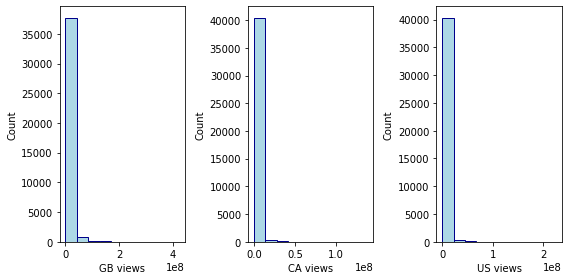

In [4]:
y1 = gb['views']
y2 = ca['views']
y3 = us['views']

fig,ax = plt.subplots(1,3,figsize=(8,4))
ax[0].hist(y1,facecolor='lightblue',ec='darkblue')
ax[1].hist(y2,facecolor='lightblue',ec='darkblue')
ax[2].hist(y3,facecolor='lightblue',ec='darkblue')

ax[0].set_xlabel('GB views')
ax[1].set_xlabel('CA views')
ax[2].set_xlabel('US views')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
ax[2].set_ylabel('Count')
plt.tight_layout()

plt.show()

If we ignore large values we can get a more detailed view of the distributions:

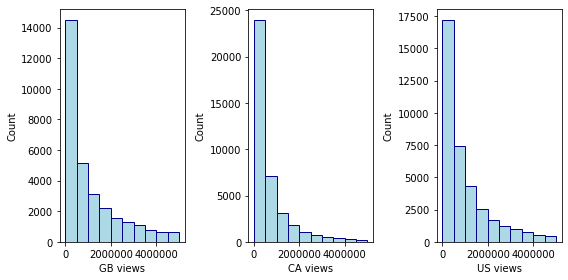

In [8]:
y1 = gb['views']
y2 = ca['views']
y3 = us['views']

y1_reduced = y1.values[np.where(y1<5e6)]
y2_reduced = y2.values[np.where(y2<5e6)]
y3_reduced = y3.values[np.where(y3<5e6)]

fig,ax = plt.subplots(1,3,figsize=(8,4))
ax[0].hist(y1_reduced,facecolor='lightblue',ec='darkblue')
ax[1].hist(y2_reduced,facecolor='lightblue',ec='darkblue')
ax[2].hist(y3_reduced,facecolor='lightblue',ec='darkblue')

ax[0].set_xlabel('GB views')
ax[1].set_xlabel('CA views')
ax[2].set_xlabel('US views')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
ax[2].set_ylabel('Count')
plt.tight_layout()

plt.show()

__Note__ we can can use a stratisfied train-test split to replicate this skew in the training data, or we can try a log transformation or a Box-Cox transformation. 

### Aspects of categorical features:

 - The US datset has only 6351 uniques entries but 6455 title, this was shown to occur because the same video is uploaded with more than one title. 
 - 56% of trending videos has two capital letters, not a great indictor of trending.
 - There is no real correlation between title length and number of views.
 - Almost all trending videos have both comments and rating enabled.

### Correlations between numerical features

For the US dataset: 

 - The correlation between views and likes is 0.85
 - The correlation between views and dislikes is 0.45
 - The correlation between views and comment count is 62
 - The correlation between comment count and likes is 0.8
 - The correlation between comment count and likes is 0.7
 
Although we wont be using these for sentiment analysis, it may be useful to bear these relationships in mind.


### Which video category has the largest number of trending videos?
It is shown for the US dataset, the entertainment categroy has the largest number of trending videos, we also look at GB and CA here. 

In [13]:
#Extract categories from the json files and store them in a dictionary.
#We then use the dictionary to build a new categories column.
#Code copied from the kaggle kernel. 

with open("GB_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
gb['category_name'] = gb['category_id'].map(cat_dict)


with open("CA_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
ca['category_name'] = ca['category_id'].map(cat_dict)


with open("US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
us['category_name'] = us['category_id'].map(cat_dict)


In [18]:
gb_category_counts = gb["category_name"].value_counts()
ca_category_counts = ca["category_name"].value_counts()
us_category_counts = us["category_name"].value_counts()

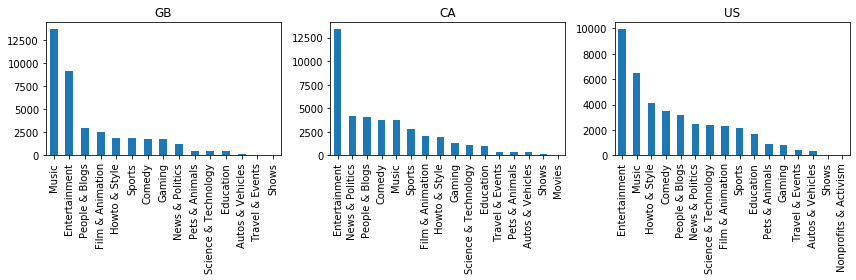

In [26]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
gb_category_counts.plot.bar(ax=ax[0])
ca_category_counts.plot.bar(ax=ax[1])
us_category_counts.plot.bar(ax=ax[2])
ax[0].set_title('GB')
ax[1].set_title('CA')
ax[2].set_title('US')
plt.tight_layout()
plt.show()

We In GB, music is the most popular while Entertainment is most popular in CA and US. Music ranks 2nd in the US but only 5th in CA. News and politics is 2nd in Canada compared 9th in GB and 5th in the US. The point is, we can expect different results from different countries. 

### Summary of 'YouTube Trending Videos Analysis' Kaggle Kernel

- Almost all data is complete. There are a few instances in which the descriptions are missing.
- The number the distribution of views has positive skew for all countries. This was also observed in number of likes and number of comments. 
- There are strong correlatons between views and likes. Other numerical attributes also have correaltions. 
- The amount of trending videos per category is different in different countries. 
- __Note__: the above analysis contains multiple entries of the same video, where videos trend across multiple days. If we want to do initial sentiment analysis we may want to only use the most recent instance of a video.

***

# Initial experiment to test if we can be use text data to predict if video will be in top 20% of viewed videos in its category. 

As an intial test, lets consider only GB and a single category. 

Steps:

- Take most popular category to begin with, but then we can repeat initial analysis for other categories later.
- Take latest unique instance for each video.
- Check distribution of views.
- Calculate percentiles for this category.
- Create column which has values Yes and No. These values will be used to label data as being in top 20% or not in top 20%
- Tokenise some text attributes.
- Try out some classifiers: first multinomial Naive Bayes. 

In [206]:
#Re-load GB data and create category column
gb = pd.read_csv('GBvideos.csv')
with open("GB_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
gb['category_name'] = gb['category_id'].map(cat_dict)


In [207]:
#Drop dubplicate instances, keeping only latest entry for each video
print(gb.shape)
gb = gb.drop_duplicates(subset='video_id',keep='last')
print(gb.shape)

(38916, 17)
(3272, 17)


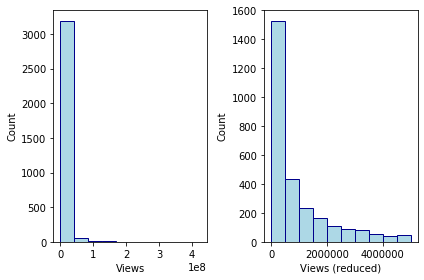

In [208]:
fig,ax = plt.subplots(1,2)

views_reduced = gb['views'].values[np.where(gb['views']<5e6)]

ax[0].hist(gb['views'],facecolor='lightblue',ec='darkblue')
ax[0].set_xlabel('Views')
ax[0].set_ylabel('Count')

ax[1].hist(views_reduced,facecolor='lightblue',ec='darkblue')
ax[1].set_xlabel('Views (reduced)')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


Positive skew persists in the the dataset of only unique values. Remember to replicate this in the train-test split. 

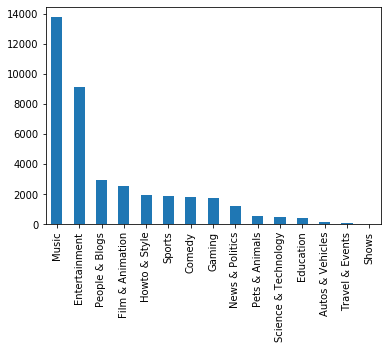

In [209]:
fig = plt.figure()
gb_category_counts.plot.bar()
plt.show()


Let us use the Music category, since it is the most popular. 

In [210]:
gb_music = gb.loc[gb['category_name']=='Music']
print(gb_music.shape)

(877, 17)


Compute the 80th percentile for this category

In [211]:
'''We will use the method of nearest-rank to calculate a percentile which should be un-affected by skew.

First we sort views in assending order
Next, calculate the ordinal rank of views.
Finally, return value from the array of ordered views ath N'th index. 
'''

def p_percentile(views_column,p=80):
    '''p is given as a percentage. Default: p=80%'''
    
    ordered_views = np.sort(views_column.values) #sort values
    N = ordered_views.shape[0] #number of values in array
    ordinal_rank = int(N*p/100) #calculate ordinal rank
    
    return ordered_views[ordinal_rank] #return the value of ordered array at index ordinal_rank

In [212]:
percentile_80 = p_percentile(gb_music['views'])
print(percentile_80)
print(gb_music['views'].mean())
print(gb_music['views'].max())

14008109
13109979.546180159
424538912


Create labels to indicate if video is in top 20% or not. We can also reset the index to make inspecting the data easier.

In [213]:
gb_music['Percentile'] = gb_music['views'].apply(lambda x: 'Yes' if x >= percentile_80 else 'No')
gb_music.reset_index(inplace=True)
print(gb_music.head)

<bound method NDFrame.head of      index     video_id trending_date  \
0       22  fiusxyygqGk      17.14.11   
1      158  kqbJCW-jxYM      17.14.11   
2      178  676hNIhKO2M      17.14.11   
3      192  lyqww9P7qyw      17.14.11   
4      193  MnK9_fWPT3Y      17.14.11   
..     ...          ...           ...   
872  38910  uKxWP56VStM      18.14.06   
873  38911  l884wKofd54      18.14.06   
874  38912  IP8k2xkhOdI      18.14.06   
875  38913  Il-an3K9pjg      18.14.06   
876  38915  4YFo4bdMO8Q      18.14.06   

                                                 title         channel_title  \
0         Marshmello - You & Me (Official Music Video)            marshmello   
1    Lil Kim Keeps It Real On Nicki Minaj, Biggie R...                HOT 97   
2    Madison Beer - Say It To My Face (Official Audio)  MadisonBeerMusicVEVO   
3    dodie - Vevo Real Guides: dodie in Belfast - S...             dodieVEVO   
4    Tee Grizzley Win (WSHH Exclusive - Official Mu...       WORLDSTARHIPHOP 

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


We will plot the distribution of labels so we can compare to the training labels after the split. We want to compare becuase we want the stratisfied splitting to replecate the skew.

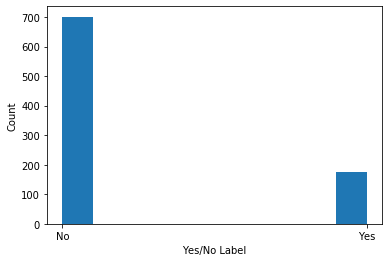

In [158]:
fig = plt.figure()
plt.hist(gb_music['Percentile'])
plt.xlabel('Yes/No Label')
plt.ylabel('Count')
plt.show()

## Text cleaning

We need to clean the text in an attempt to reduce the dimensionality of the feature space. We will see below that some descriptions contain hyperlinks. Furthemore, some desctiptions contain Korean, Chinese and Japanese script. This is the same for some video titles and tags. We want to remove the links, non-latin characters, punctuation and remove stop words. We will write a function to perform all three stages. 

In [147]:
print(gb_music['description'][0:20])

0     PURCHASE YOU & ME HERE ▶ https://smarturl.it/m...
1     HOT 97 App: http://www.hot97.com/hot97app\n\nY...
2     Stream & Download ‘Say It To My Face’ now from...
3     Join dodie on a tour of Belfast before her hea...
4     Watch the official music video for Win by Tee ...
5     Trigger Warning: This video portrays subtle ye...
6     Get an unprecedented glimpse into Taylor's son...
7     Get “Cinema Paradiso” from our album “Score” a...
8     Get Taylor Swift’s new album, reputation, here...
9     Music video by Luke Bryan performing Most Peop...
10    사랑에 빠져 돌아온 러블리즈, 추운 겨울 두근대는 설레임을 담은 세 번째 미니앨범 ...
11    Remy Ma - Wake Me Up featuring Lil' Kim (Offic...
12    Get Taylor Swift’s new album, reputation, incl...
13    Listen to MotorSport (feat. Nicki Minaj & Card...
14    Video Description:\n12/29: Neon City: The Lost...
15    New Music from Miguel - Told You So\niTunes – ...
16    Lemon performed by N.E.R.D and Rihanna is out ...
17    Official audio for Vance Joy Like Gold\n\n

We can see that some descriptions contain Koren, Chinese and Japanese text, this is also the case with some titles and tags. For now we don't want to process these scrips and we should filter them out. To do this we can use Pythons re module.

In [84]:
#Example of description containing Korean text
print(gb_music['description'][10])

사랑에 빠져 돌아온 러블리즈, 추운 겨울 두근대는 설레임을 담은 세 번째 미니앨범 발매!\nLovelyz 3rd Mini Album [Fall in Lovelyz]\n\n \n그룹 러블리즈가 11월 14일 미니 3집 [Fall in Lovelyz]을 발매하며 깜짝 컴백한다.\n\n러블리즈는 지난 2월 정규 2집 [R U Ready?]와 5월 정규 2집 리패키지 [지금, 우리]를 발매하며\n두 번째 단독 콘서트 ‘Alwayz’까지 성황리에 마쳤으며 하반기에도 활발한 활동을 펼치고자\n미니 3집 앨범을 발매하기로 결정. 또 한 번 겨울의 러블리즈를 볼 수 있게 됐다.\n이번 미니 3집은 러블리즈만의 감성이 가장 돋보일 수 있는 계절인 겨울에 찾아오는 것으로\n매 앨범 마다 높은 완성도와 한층 성장된 실력으로 컴백하는 만큼, 앨범에 대한 관심이 뜨겁다.\n특히, 이번 앨범에서는 최근 떠오르는 프로듀서인 원택(1Take)과 탁(TAK)의 협업으로\n새로운 러블리즈만의 감성과 세계관을 성립하며 또 다른 시너지를 만들어 낼 것이다.\n\n\n\n러블리즈는 2014년 11월 12일 특유의 사랑스러움과 청순함으로 가요계에 대체 불가능한 걸그룹으로서\n\n\n첫 1위와 두 번의 단독 콘서트, 뮤지컬까지 다방면으로 활동하고 있는 가운데 미니 3집으로 전격 컴백을 알렸다.\n데뷔 3주년의 의미를 담은 이번 앨범은 러블리즈를 항상 응원하고 사랑해준 팬들을 위해 러블리즈가 선사하는\n선물 같은 앨범으로 어느 때 보다 정성을 다해 완성됐다.\n\n앨범 명 ‘Fall in Lovelyz’는 늦은 가을에서 겨울로 넘어가는 사이 계절의 분위기와 러블리즈만의\n특별한 감성을 담아 지어졌으며, 사랑에 빠진 러블리즈와 이들에게 빠지게 될 모든 사람들의\n설레고 벅찬 감정을 오롯이 표현하는 앨범이라는 의미를 담았다.\n\n러블리즈의 미니 3집에는 타이틀 곡 ‘종소리’을 포함 총 7곡으로 모두 신곡으로 채워졌다.\n트랙에는 잔잔하게 퍼지는 여운을 담은 발라드부터 동화 속의 한 장면을 연상케 하는 몽

In [136]:
import re

#example case
x = gb_music['description'][10]
x = re.sub("([^\x00-\x7F])+"," ",x) #filter out non-latin characters
print(x)
print(type(x))

       ,                  !\nLovelyz 3rd Mini Album [Fall in Lovelyz]\n\n \n    11  14    3  [Fall in Lovelyz]       .\n\n    2    2  [R U Ready?]  5    2    [ ,  ]   \n         Alwayz             \n  3       .                  .\n    3                     \n                   ,        .\n ,            (1Take)   (TAK)   \n                     .\n\n\n\n  2014  11  12               \n\n\n  1         ,             3       .\n  3                         \n                 .\n\n     Fall in Lovelyz                 \n       ,                \n               .\n\n    3            7       .\n                           \n             .\n\n            Complextro   ELECTRO-POP       \n (1Take),  (TAK)   ,    .              (1Take),  (TAK) \n   AIR ,                    .\n     ,              \n               .\n\n ,                          \n                     .\n       Spotlight     ,  ,  FALLIN ,  ,       7   .\n                     ,        \n                     .\n ,  FALLIN    7          

We have a lot of new line characters which we should also filter out before removing the punctuation

In [137]:
#x = re.sub(r'\b\w{1,3}\b', '', x) # remove all characters length 3 or less
#print(x)

In [138]:
#download list of English stopwords from nltk
import string
import nltk
from nltk.corpus import stopwords

In [139]:
def text_normalise(message):
    
    '''Input: string
    
    1) Remove any links.
    2) Remove any Asian characters.
    3) Remove words length 3 or less, these tend to be special character such as \n, single numerical digits
    and generally unimportant words.
    4) Remove punctuation and return a list of strings.
    5) Make all words lower-case and remove stopwords from list.
    
    Returns: list of strings'''
    message = re.sub(r"http\S+", "", str(message)) #remove any links
    message = re.sub("([^\x00-\x7F])+"," ",str(message)) #remove any non-latin characters
    message = re.sub(r'\b\w{1,3}\b', '', message) # remove all words length 3 or less
    no_punc = ''.join([char for char in message if char not in string.punctuation]) #remove punctuation return list of string
    no_stopwords = [word.lower() for word in no_punc.split() if word.lower() not in stopwords.words('english')] #remove stopwords
    return no_stopwords


normal_x = text_normalise(x)
print(normal_x)

['nlovelyz', 'mini', 'album', 'fall', 'lovelyz', 'fall', 'lovelyz', 'ready', 'alwayz', '1take', '2014', 'fall', 'lovelyz', 'complextro', 'electro', '1take', '1take', 'spotlight', 'fallin', 'fallin', 'alwayz', 'fall', 'lovelyz', 'music', 'music', 'youtube', 'music', 'music', 'business', 'brand', 'asia', 'entertainment', 'company', 'music', 'covers', 'investment', 'production', 'distribution', 'album', 'also', 'provides', 'best', 'music', 'festival', 'concerts', 'meet', 'artists', 'brand', 'music', 'videos', 'exclusive', 'video', 'clips', 'official', 'youtube', 'music']


Test this function on the video descriptions:

In [134]:
descriptons = gb_music['description']
normalised_desc = descriptons.apply(text_normalise)
print(normalised_desc)

0      [purchase, httpssmarturlmelloyouandmenwatch, w...
1      [httphot97hot97app, subscribe, http12ln6vbnhtt...
2      [stream, download, face, favourite, local, ret...
3      [join, dodie, tour, belfast, headline, show, m...
4      [watch, official, music, video, grizzleynstrea...
                             ...                        
872    [people, watching, video, hope, feel, comfort,...
873    [song, move, miami, feat, pitbull, click, show...
874    [official, music, video, single, available, ev...
875    [2002, annemarie, http2002get, speak, mind, de...
876    [debut, album, light, mine, httpkylelightofmin...
Name: description, Length: 877, dtype: object


## Testing out a classifier

We have a function which cleans strings (this could perhaps be improved but for now, let's see how it goes) and a column which labels each video as being in the top 20% or not in the top 20%. Let's try using the cleaned descriptions as a predictor variable. Going forward we would probably want the model to consider multiple text attributes and select the k best. I will first try a multinomial Naive Bayes classifier.

In [151]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict


In [202]:
#define data to use in classifier and drop instances with missing description

gb_music_data = gb_music[['description','Percentile']]
print(gb_music_data.shape)
gb_music_data = gb_music_data[gb_music_data['description'].notna()]
print(gb_music_data.shape)


(877, 2)
(869, 2)


In [185]:
#Create train test split

X = gb_music_data['description']
y = gb_music_data['Percentile']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


242     No
687    Yes
477     No
745     No
625     No
      ... 
97      No
397     No
333     No
382     No
264     No
Name: Percentile, Length: 695, dtype: object


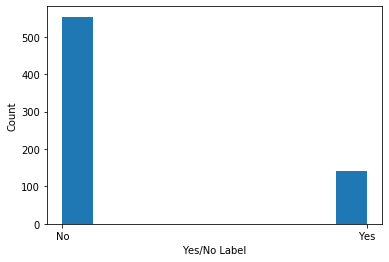

In [187]:
print(y_train)
fig = plt.figure()
plt.hist(y_train)
plt.xlabel('Yes/No Label')
plt.ylabel('Count')
plt.show()

The ratio of Yes to No is similar to that shown above, before we split the data, so we can assume that the sampling has reproduced the imbalance between categories. We can now build a pipeline to clean and vectorise the text, and pass it to a classifier. To begin with we try a simple Bag-of-words model which can be acheived using the CountVectorizer class. It is possible to clean the data by passing our cleaning function 'text_normalise' to the analyzer of the CountVectorizer.

In [188]:
pipeline = Pipeline([('vect',CountVectorizer(analyzer=text_normalise)),('nbm',MultinomialNB())]) #create pipeline
predictions = cross_val_predict(pipeline,X_train,y_train,cv=3) #use cross validated predictions

In [190]:
from sklearn.metrics import confusion_matrix

confusion_matrix_cv = confusion_matrix(y_train,predictions)

print(confusion_matrix_cv)

def precision_score(confusion_mat):
    return confusion_matrix_cv[1,1]/(confusion_matrix_cv[1,1]+confusion_matrix_cv[0,1])

def recall_score(confusion_matrix_cv):
    return confusion_matrix_cv[1,1]/(confusion_matrix_cv[1,1]+confusion_matrix_cv[1,0])

def f1_score(confusion_mat):
    precision = precision_score(confusion_matrix_cv)
    recall = recall_score(confusion_matrix_cv)
    return 2*precision*recall/(precision+recall)

precision = precision_score(confusion_matrix_cv)
recall = recall_score(confusion_matrix_cv)
f1 = f1_score(confusion_matrix_cv)

print('Confusion matrix:')
print(confusion_matrix_cv)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

[[518  36]
 [100  41]]
Confusion matrix:
[[518  36]
 [100  41]]
Precision: 0.5324675324675324
Recall: 0.2907801418439716
F1-score: 0.3761467889908257


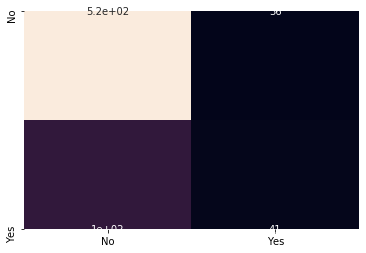

In [197]:
import seaborn as sns
labels=['No','Yes']
annot_kws = {"ha": 'left',"va": 'top'}
ax = sns.heatmap(confusion_matrix_cv,annot=True,xticklabels=labels, yticklabels=labels,cbar=False)


In [199]:
#Convert the No/Yes strings into integers 0/1.
def string_to_int(array):
    binary_array = np.zeros(len(array))
    ones = np.argwhere(array == 'Yes')
    binary_array[ones] = 1
    return binary_array.astype(int)

#Convert labels into a binary format
binary_labels = string_to_int(y_train.values)

#Get the probabilities using cross_val_predict
train_probabilities = cross_val_predict(pipeline,X_train,y_train,cv=3,method='predict_proba')

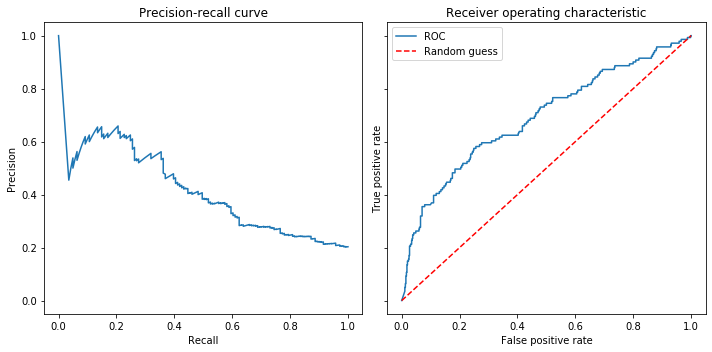

In [200]:
from sklearn.metrics import precision_recall_curve, roc_curve


#Calclate precision, recall, fpr and tpr
precisions, recalls, thresholds = precision_recall_curve(binary_labels,train_probabilities[:,1],pos_label=None)
fpr, tpr, thresholds = roc_curve(binary_labels,train_probabilities[:,1],drop_intermediate=True)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row',figsize=(10,5))
ax[0].plot(recalls,precisions)
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Recall')
ax[0].set_title('Precision-recall curve')
ax[1].plot(fpr,tpr, label='ROC')
ax[1].plot(fpr,fpr,'r--', label='Random guess')
ax[1].set_ylabel('True positive rate')
ax[1].set_xlabel('False positive rate')
ax[1].set_title('Receiver operating characteristic')
ax[1].legend()
plt.tight_layout()
plt.show()